In [10]:
import numpy as np
import matplotlib.pyplot as plt

## Active Learning Example in modAL framework

In [11]:
# noisy sine function
X = np.random.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
y = np.sin(X) + np.random.normal(scale=0.3, size=X.shape)

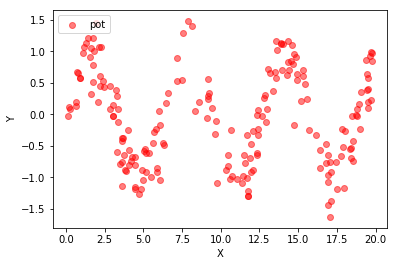

In [12]:
plt.scatter(X, y, c="r", alpha=0.5, label="pot")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc=2)
plt.show()

For active learning, we shall define a **custom query strategy** tailored to Gaussian processes(for this example). 

In a nutshell, a **query stategy** in modAL is a function taking (at least) **two** arguments, outputting the index of the queried instance and the instance itself. In our case, the arguments are *regressor* and X.

Two arguments:
- an estimator object
- a pool of examples  



In [13]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

In [14]:
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

n_initial = 5
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_training, y_training = X[initial_idx], y[initial_idx]

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)

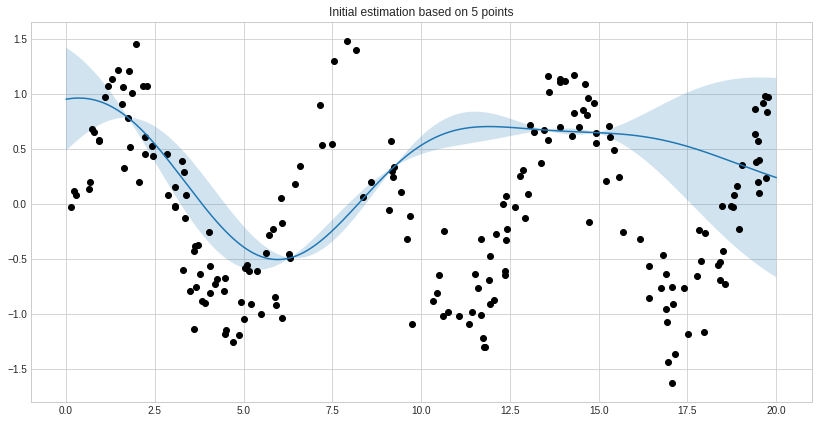

In [15]:
# plotting the initial estimation
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(0, 20, 1000)
    pred, std = regressor.predict(x.reshape(-1,1), return_std=True)
    plt.plot(x, pred)
    plt.fill_between(x, pred.reshape(-1, ) - std, pred.reshape(-1, )+std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Initial estimation based on %d points' % n_initial)
    plt.show()

In [16]:
# active learning
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X)
    regressor.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))

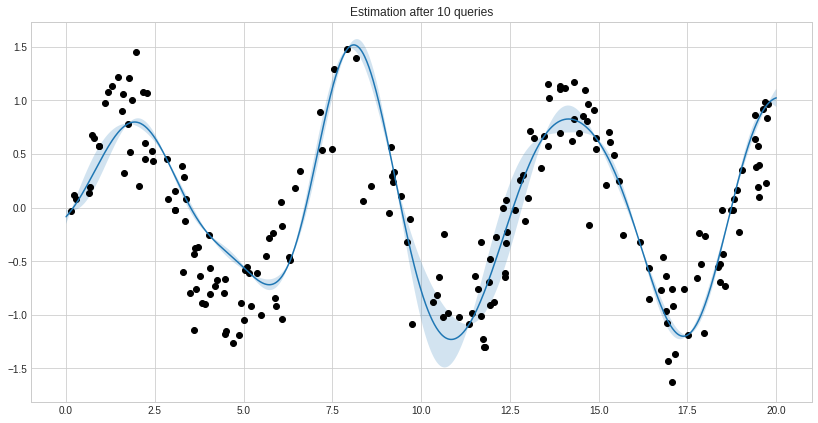

In [17]:
# plotting after active learning
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(0, 20, 1000)
    pred, std = regressor.predict(x.reshape(-1,1), return_std=True)
    plt.plot(x, pred)
    plt.fill_between(x, pred.reshape(-1, )-std, pred.reshape(-1, )+std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Estimation after %d queries' % n_queries)
    plt.show()